In [3]:
# load json file as dictionary
import json
import sys
import pandas as pd
import numpy as np
import re

from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import bertopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
import datamapplot
import nbformat

import seaborn as sns
import matplotlib.pyplot as plt


In [26]:
patents_text = pd.read_csv("patents_text_topic_modelling2.csv")

/var/folders/jy/j77v476x03737ryp7gll_0p00000gn/T/ipykernel_27382/3127923996.py:1: DtypeWarning:

Columns (18,20,21,23,49,50) have mixed types. Specify dtype option on import or set low_memory=False.



In [27]:
patents_text['title'] = patents_text['title'].fillna('')
patents_text['abstract'] = patents_text['abstract'].fillna('')
patents_text['description'] = patents_text['description'].fillna('')
patents_text['claims'] = patents_text['claims'].fillna('')

## Full embeddings

In [31]:
aifors = patents_text[(patents_text['SofAI'] == 0) & (patents_text['AIforS'] == 1)]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = aifors['title'] + aifors['abstract'] + aifors["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [32]:
len(abstracts)

17302

In [19]:
# Load embeddings
embeddings_specter = np.load('embeddings_specter_aifors_large.npy')

In [35]:
def extract_cpc_prefix_set(cpc_string):
    cpc_string = cpc_string.strip("[]").replace("'", "")
    cpc_list = cpc_string.split(", ")
    cpc_prefixes = [code[:4] for code in cpc_list]
    return set(cpc_prefixes)

# Apply the function to each row in the 'cpc_codes_EPO' column
aifors['cpc_code_set'] = aifors['cpc_codes_EPO'].apply(extract_cpc_prefix_set)

print(aifors.cpc_code_set)
# Convert sets to frozensets to make them hashable
frozenset_list = aifors['cpc_code_set'].apply(frozenset)

# Get the number of unique frozensets
unique_frozensets = frozenset_list.nunique()

print("Number of unique sets of CPC code prefixes:", unique_frozensets)

0                          {B01D}
1              {B60W, B60K, Y02T}
2              {G06F, H04W, Y02D}
3              {Y04S, Y02E, H02J}
4                    {Y02B, H02M}
                   ...           
20440                {Y04S, H02J}
20441    {H02J, Y02B, H02M, B60L}
20442                {Y02B, H02M}
20443                {Y02B, H05B}
20444                {Y02B, H05B}
Name: cpc_code_set, Length: 19802, dtype: object
Number of unique sets of CPC code prefixes: 7645


In [36]:
# Filter the DataFrame to exclude patents with CPC codes starting with 'Y'
y_cpc_patents = aifors[aifors['cpc_code_set'].apply(lambda x: any(code.startswith('Y02') for code in x))]

# Count the number of such patents
num_y_cpc_patents = y_cpc_patents.shape[0]

print("Number of patents without CPC code starting with 'Y':", num_y_cpc_patents)

Number of patents without CPC code starting with 'Y': 16500


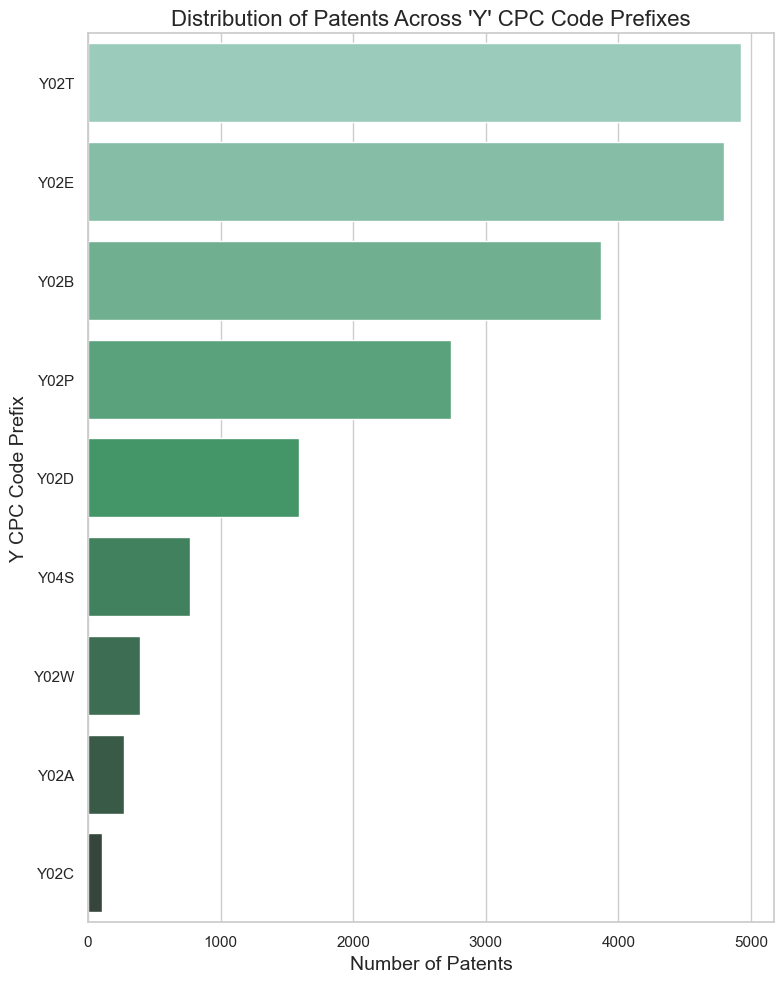

In [38]:
# Step 2: Extract 'Y' code prefixes from the filtered patents
def extract_y_prefixes(cpc_set):
    return [code for code in cpc_set if code.startswith('Y0')]

y_prefixes = y_cpc_patents['cpc_code_set'].apply(extract_y_prefixes)

# Flatten the list of 'Y' prefixes
all_y_prefixes = [prefix for sublist in y_prefixes for prefix in sublist]

# Create a DataFrame for plotting
y_prefix_counts = pd.Series(all_y_prefixes).value_counts().reset_index()
y_prefix_counts.columns = ['Y CPC Prefix', 'Count']

# Step 3: Plot the distribution using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 10))  # Adjust the size to make it more suitable for vertical plotting
palette = sns.color_palette("BuGn_d", n_colors=len(y_prefix_counts))
ax = sns.barplot(y='Y CPC Prefix', x='Count', data=y_prefix_counts, palette=palette)
ax.set_title("Distribution of Patents Across 'Y' CPC Code Prefixes", fontsize=16)
ax.set_ylabel("Y CPC Code Prefix", fontsize=14)
ax.set_xlabel("Number of Patents", fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

0                {B0}
1            {B6, Y0}
2        {G0, Y0, H0}
3            {H0, Y0}
4            {H0, Y0}
             ...     
20440        {H0, Y0}
20441    {H0, B6, Y0}
20442        {H0, Y0}
20443        {H0, Y0}
20444        {H0, Y0}
Name: cpc_code_set, Length: 19802, dtype: object
Number of unique sets of CPC code prefixes: 1142


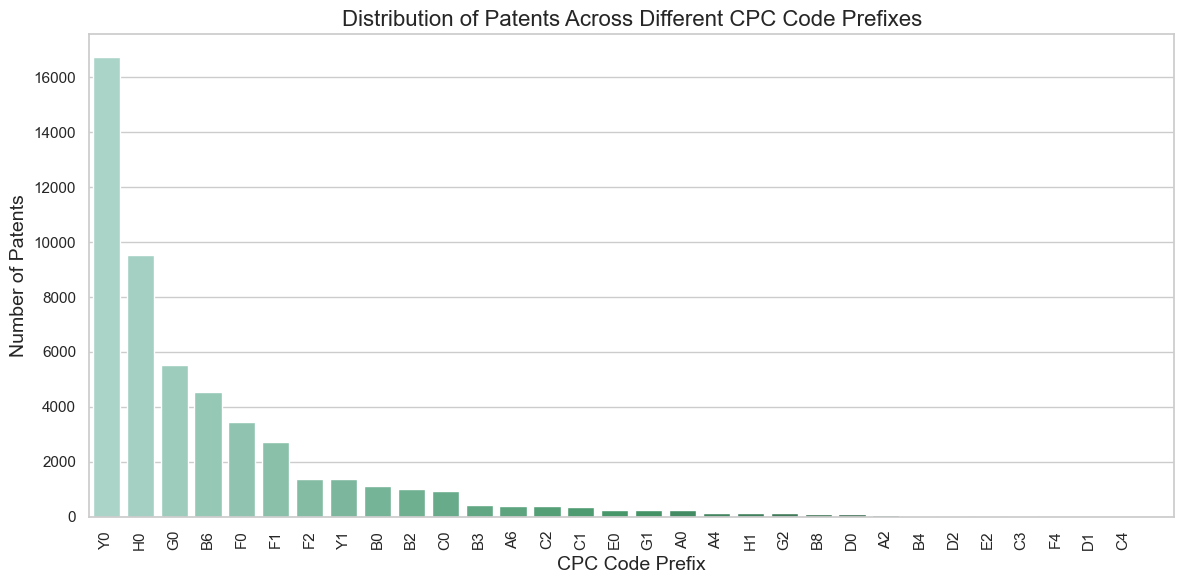

In [41]:
def extract_cpc_prefix_set(cpc_string):
    cpc_string = cpc_string.strip("[]").replace("'", "")
    cpc_list = cpc_string.split(", ")
    cpc_prefixes = [code[:2] for code in cpc_list]
    return set(cpc_prefixes)

# Apply the function to each row in the 'cpc_codes_EPO' column
aifors['cpc_code_set'] = aifors['cpc_codes_EPO'].apply(extract_cpc_prefix_set)

print(aifors.cpc_code_set)
# Convert sets to frozensets to make them hashable
frozenset_list = aifors['cpc_code_set'].apply(frozenset)

# Get the number of unique frozensets
unique_frozensets = frozenset_list.nunique()

print("Number of unique sets of CPC code prefixes:", unique_frozensets)

# Flatten the sets of prefixes into a single list
all_prefixes = [prefix for prefix_set in aifors['cpc_code_set'] for prefix in prefix_set]

# Create a DataFrame for plotting
prefix_counts = pd.Series(all_prefixes).value_counts().reset_index()
prefix_counts.columns = ['CPC Prefix', 'Count']

# Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("BuGn_d", n_colors=len(prefix_counts))
ax = sns.barplot(x='CPC Prefix', y='Count', data=prefix_counts, palette=palette)
ax.set_title("Distribution of Patents Across Different CPC Code Prefixes", fontsize=16)
ax.set_xlabel("CPC Code Prefix", fontsize=14)
ax.set_ylabel("Number of Patents", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

In [47]:
# Filter the DataFrame to exclude patents with CPC codes starting with 'Y'
no_y_cpc_patents = aifors[~aifors['cpc_code_set'].apply(lambda x: any(code.startswith('Y0') or 
                                                                      code.startswith('F1') or 
                                                                      code.startswith('F0') or
                                                                      code.startswith('B6') or
                                                                      code.startswith('H0') or
                                                                      code.startswith('G0') or
                                                                      code.startswith('B0') or
                                                                      code.startswith('C0') or
                                                                      code.startswith('A0') or
                                                                      code.startswith('A6') or
                                                                      code.startswith('F2') 
                                                                      for code in x))]

# Count the number of such patents
num_no_y_cpc_patents = no_y_cpc_patents.shape[0]

print("Number of patents without CPC code starting with 'Y':", num_no_y_cpc_patents)

Number of patents without CPC code starting with 'Y': 31


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
def extract_cpc_prefix_set(cpc_string):
    cpc_string = cpc_string.strip("[]").replace("'", "")
    cpc_list = cpc_string.split(", ")
    cpc_prefixes = [code[:2] for code in cpc_list]
    return set(cpc_prefixes)

# Apply the function to each row in the 'cpc_codes_EPO' column
aifors['cpc_code_set'] = aifors['cpc_codes_EPO'].apply(extract_cpc_prefix_set)

# First dictionary for mapping non-Y patents to Y0 categories
non_y_mapping = {
    'F1': 'Y02P', 'F0': 'Y02E', 'B6': 'Y02T', 'H0': 'Y02B', 'G0': 'Y02P',
    'B0': 'Y02P', 'C0': 'Y02P', 'A0': 'Y02P', 'A6': 'Y02P', 'F2': 'Y02B'
}

# Second dictionary for mapping Y0 categories to broader categories
y_category_mapping = {
    'Y02A': 'Adaption', 'Y02B': 'Buildings', 'Y02C': 'Carbon capture',
    'Y02I': 'ICT', 'Y02E': 'Energy generation, transmission or distribution',
    'Y02P': 'Production or processing', 'Y02T': 'Transportation',
    'Y02W': 'Wastewater treatment or management', 'Y04S': 'Smart grid'
}

# Function to map non-Y patents to Y0 categories
def map_non_y_prefixes(cpc_set):
    mapped = []
    for code in cpc_set:
        if code.startswith('Y0'):
            mapped.append(code)
        elif code in non_y_mapping:
            mapped.append(non_y_mapping[code])
    return mapped

# Apply the mapping function to the patents
mapped_prefixes = y_cpc_patents['cpc_code_set'].apply(map_non_y_prefixes)

# Flatten the list of prefixes
all_prefixes = [prefix for sublist in mapped_prefixes for prefix in sublist]

# Create a DataFrame for plotting
prefix_counts = pd.Series(all_prefixes).value_counts().reset_index()
prefix_counts.columns = ['CPC Prefix', 'Count']

# Map the prefixes to broader categories
prefix_counts['Category'] = prefix_counts['CPC Prefix'].map(y_category_mapping)

# Aggregate the counts by category
category_counts = prefix_counts.groupby('Category')['Count'].sum().reset_index()

# Plot the distribution using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 10))
palette = sns.color_palette("BuGn_d", n_colors=len(category_counts))
ax = sns.barplot(y='Category', x='Count', data=category_counts, palette=palette)
ax.set_title("Distribution of Patents Across Categories", fontsize=16)
ax.set_ylabel("Category", fontsize=14)
ax.set_xlabel("Number of Patents", fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()


F1: Engineering (general) -> production
F0: Engines and Pumps -> energy
B6: Transport -> transport
H0: Electrics -> buildings
G0: Instruments -> production
B0: Separating, mixing -> production
C0: Chemistry -> production
A0: Agriculture -> production
A6: Health, amusement -> production
F2: lighting, heating -> buildings

Adaption
Buildings (housing, house appliances, related end-user applications)
Carbon capture
ICT
Energy generation, transmission or distribution
Production or processing
transport
Wastewater treatment or mamangement
grid

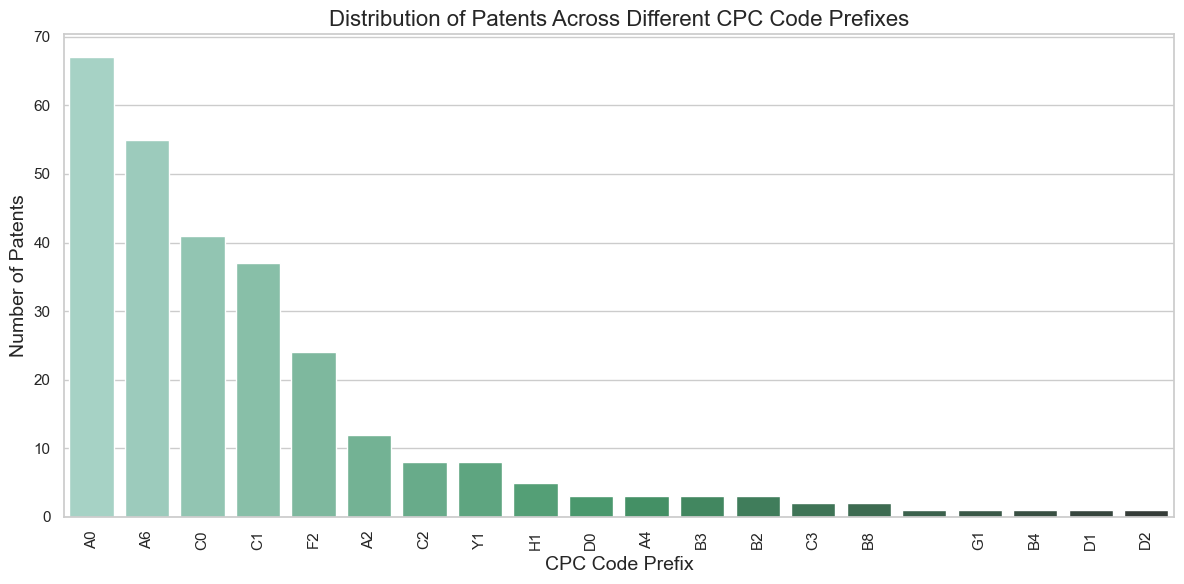

In [44]:
# Flatten the sets of prefixes into a single list
all_prefixes = [prefix for prefix_set in no_y_cpc_patents['cpc_code_set'] for prefix in prefix_set]

# Create a DataFrame for plotting
prefix_counts = pd.Series(all_prefixes).value_counts().reset_index()
prefix_counts.columns = ['CPC Prefix', 'Count']

# Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("BuGn_d", n_colors=len(prefix_counts))
ax = sns.barplot(x='CPC Prefix', y='Count', data=prefix_counts, palette=palette)
ax.set_title("Distribution of Patents Across Different CPC Code Prefixes", fontsize=16)
ax.set_xlabel("CPC Code Prefix", fontsize=14)
ax.set_ylabel("Number of Patents", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

F1: Engineering (general)
F0: Engines and Pumps
B6: Transport
H0: Electrics
G0: Instruments
B0: Separating, mixing
Y1: 
F2: Lighting, heating
C0: Chemistry
A0:
A6:
C1:
F2

In [15]:
# Define the function to extract individual CPC codes
def extract_cpc_codes(cpc_string):
    cpc_string = cpc_string.strip("[]").replace("'", "")
    cpc_list = cpc_string.split(", ")
    cpc_prefixes = [code[:2] for code in cpc_list]
    return cpc_prefixes

# Apply the function to each row in the 'cpc_codes_EPO' column and flatten the list
all_cpc_codes = aifors['cpc_codes_EPO'].apply(extract_cpc_codes).explode()

# Get the number of unique CPC codes
unique_cpc_codes = all_cpc_codes.nunique()
print(set(all_cpc_codes))

print("Number of unique individual CPC codes:", unique_cpc_codes)
print(unique_cpc_codes)

{'', 'A4', 'D0', 'H0', 'Y1', 'C3', 'A0', 'A6', 'E2', 'E0', 'B0', 'B8', 'C1', 'C2', 'D1', 'F2', 'G2', 'F4', 'B2', 'F1', 'F0', 'H1', 'A2', 'Y0', 'D2', 'B6', 'G0', 'B4', 'C4', 'B3', 'G1', 'C0'}
Number of unique individual CPC codes: 32
32


In [49]:
# Create a mapping from each unique frozenset to a unique integer
unique_frozensets = frozenset_list.unique()
frozenset_to_int = {frozenset_: idx + 1 for idx, frozenset_ in enumerate(unique_frozensets)}

# Map the frozensets to integers and create a new column
aifors['unique_code'] = frozenset_list.map(frozenset_to_int)

In [50]:
categories = aifors["unique_code"]

In [51]:
# prevent stochastic behaviour
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [52]:
# control number of topics
hdbscan_model = HDBSCAN(min_cluster_size=80, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [53]:
# improve representation by preprocessing topic representations after documents are assigned
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

In [54]:
# use additional representations
# KeyBERT
keybert_model = KeyBERTInspired()

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model
}

In [55]:
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model_specter,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

In [56]:
# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings_specter, y= categories)



2024-07-09 10:28:03,742 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-09 10:28:30,526 - BERTopic - Dimensionality - Completed ✓
2024-07-09 10:28:30,528 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-09 10:28:32,772 - BERTopic - Cluster - Completed ✓
2024-07-09 10:28:32,782 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-09 10:29:02,118 - BERTopic - Representation - Completed ✓


In [58]:
new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", embeddings=embeddings_specter)

In [59]:
topic_model.update_topics(abstracts, topics=new_topics)


2024-07-09 10:29:17,672 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [60]:
# Show topics
pd.set_option("display.max_rows", None)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,2772,0_power_voltage_dc_the,"[power, voltage, dc, the, converter, to, circu...","[power converter, dc converter, dc power, dc v...","[power, voltage, dc, converter, circuit, curre...",[multichannel regulated dc/dc converter for re...
1,1,2199,1_gear_shaft_transmission_the,"[gear, shaft, transmission, the, and, clutch, ...","[gear set, gearbox, motor vehicle, gears, ring...","[gear, shaft, transmission, clutch, input shaf...",[gearboxthe gearbox has an input shaft connect...
2,2,1472,2_the_of_to_and,"[the, of, to, and, device, data, in, power, fo...","[mobile terminal, electronic device, devices, ...","[device, power, data, user, display, informati...",[portable terminal having display and method f...
3,3,1144,3_engine_the_combustion_fuel,"[engine, the, combustion, fuel, exhaust, of, v...","[combustion engine, combustion engines, combus...","[engine, combustion, fuel, exhaust, valve, int...",[method to operate a direct injection internal...
4,4,1045,4_light_led_lighting_the,"[light, led, lighting, the, lamp, circuit, to,...","[lighting device, control circuit, power suppl...","[light, led, lighting, lamp, circuit, voltage,...",[led driving device and power supply device in...
5,5,1077,5_vehicle_the_of_control,"[vehicle, the, of, control, to, is, and, an, m...","[motor vehicle, electric vehicle, vehicle cont...","[vehicle, control, motor, engine, electric, sp...","[motor vehicle, external control device and me..."
6,6,948,6_battery_power_the_charging,"[battery, power, the, charging, electric, vehi...","[power storage, electric vehicles, electric ve...","[battery, charging, power, electric, vehicle, ...",[charging device for power storage device and ...
7,7,961,7_data_of_the_process,"[data, of, the, process, and, for, to, in, or,...","[process control, industrial, manufacturing pr...","[data, process, production, manufacturing, mod...","[control device, control method, and programto..."
8,8,672,8_communication_wireless_the_signal,"[communication, wireless, the, signal, and, to...","[wireless, wireless communication, communicati...","[communication, wireless, signal, network, rad...",[mobile communication system and wireless appa...
9,9,871,9_heat_the_air_of,"[heat, the, air, of, water, and, to, in, heati...","[heat exchanger, heater, heat pump, air condit...","[heat, air, water, temperature, exchanger, hea...",[multi-type air conditionerprovided is a multi...


In [65]:
pd.reset_option("display.max_colwidth", None)
topic_model.get_topic_info(16)

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,16,583,16_waste_the_and_of,"[waste, the, and, of, water, in, for, is, to, ...","[wastewater treatment, sewage treatment, water...","[waste, treatment, water, sludge, tank, proces...",[installation and process for purification of ...


In [74]:
# or use one of the other topic representations, like KeyBERTInspired
keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
topic_model.set_topic_labels(keybert_topic_labels)



In [ ]:
# or ChatGPT's labels
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

In [77]:
topic_model.visualize_hierarchy(custom_labels=True)

In [83]:
topic_model.visualize_heatmap(top_n_topics=26, n_clusters=3, custom_labels=True)

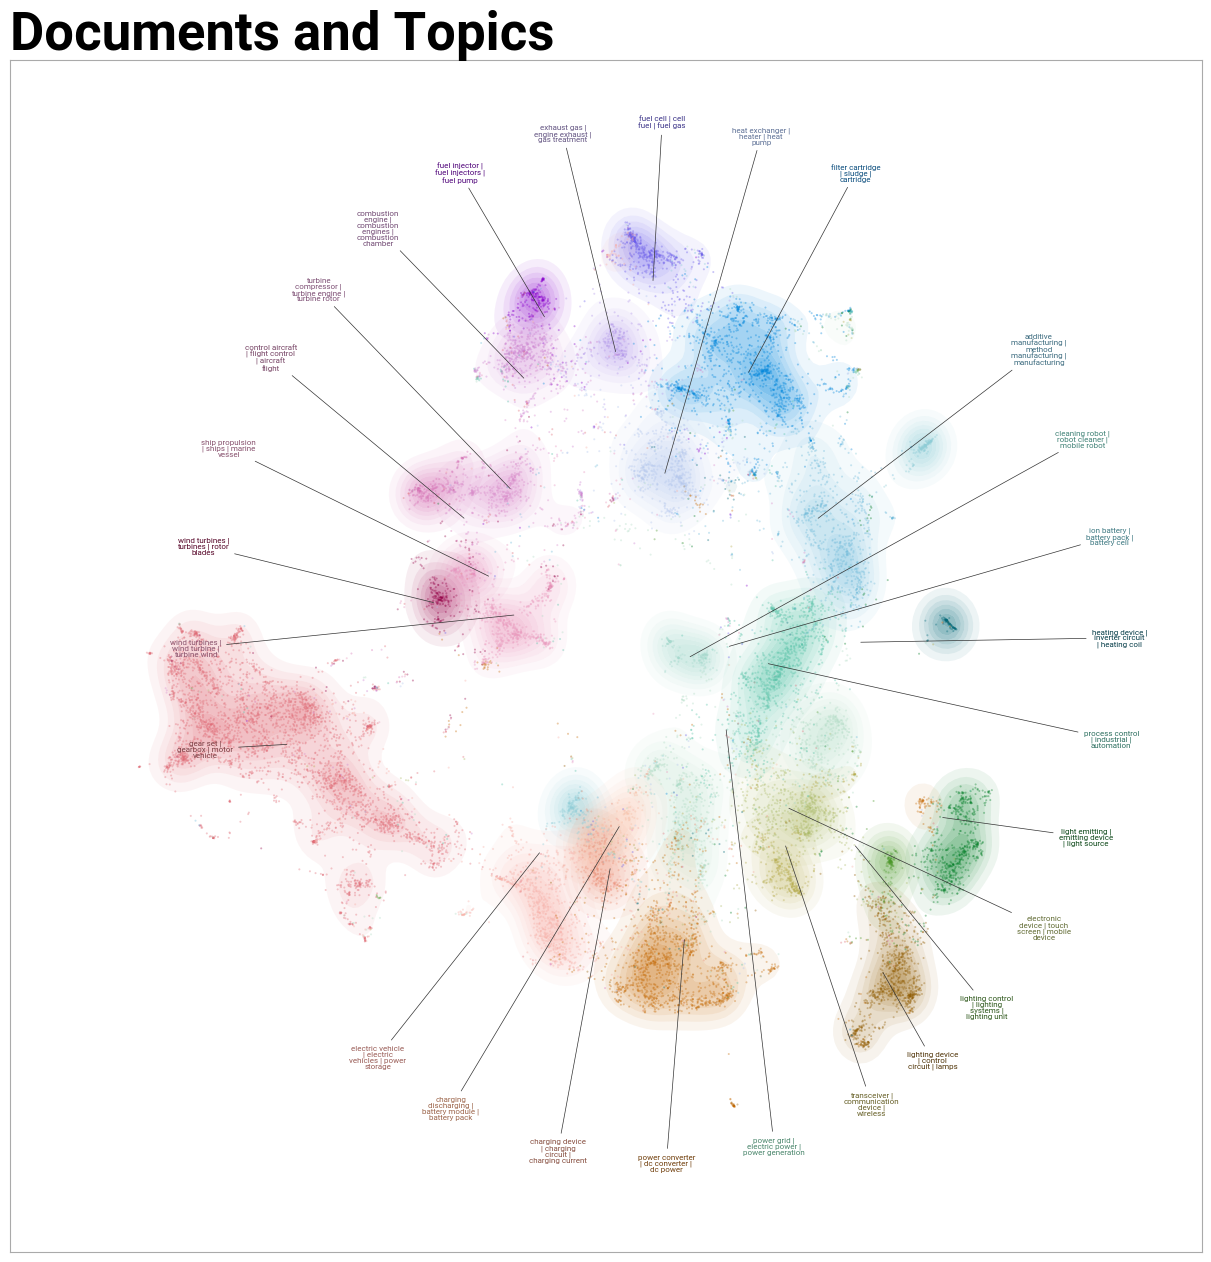

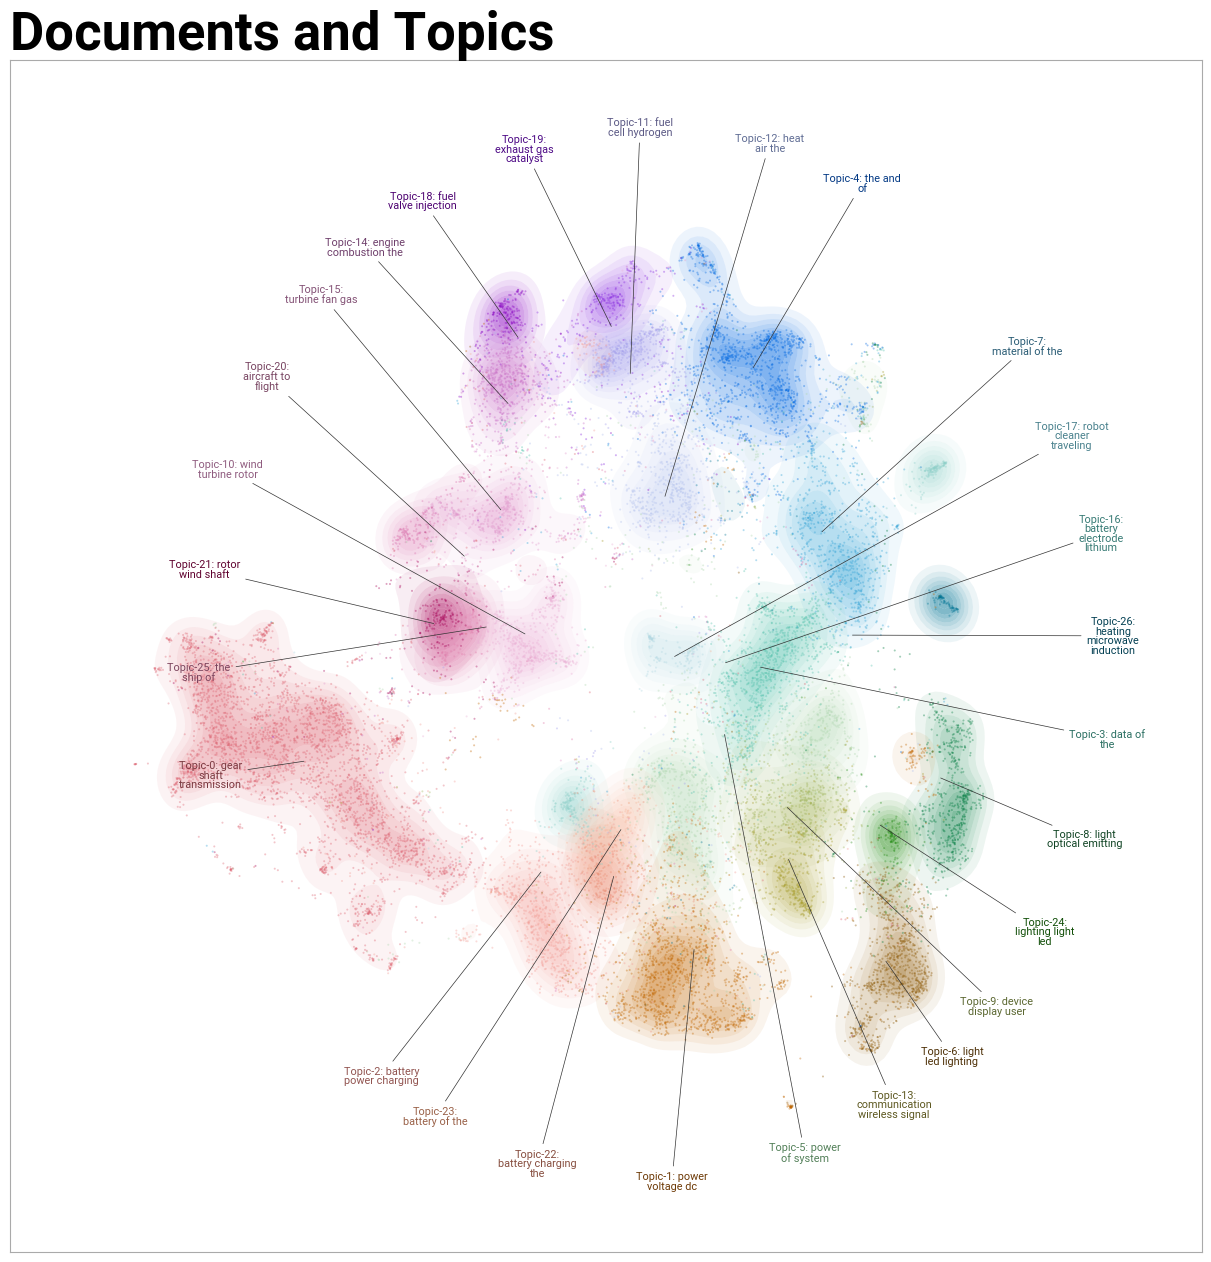

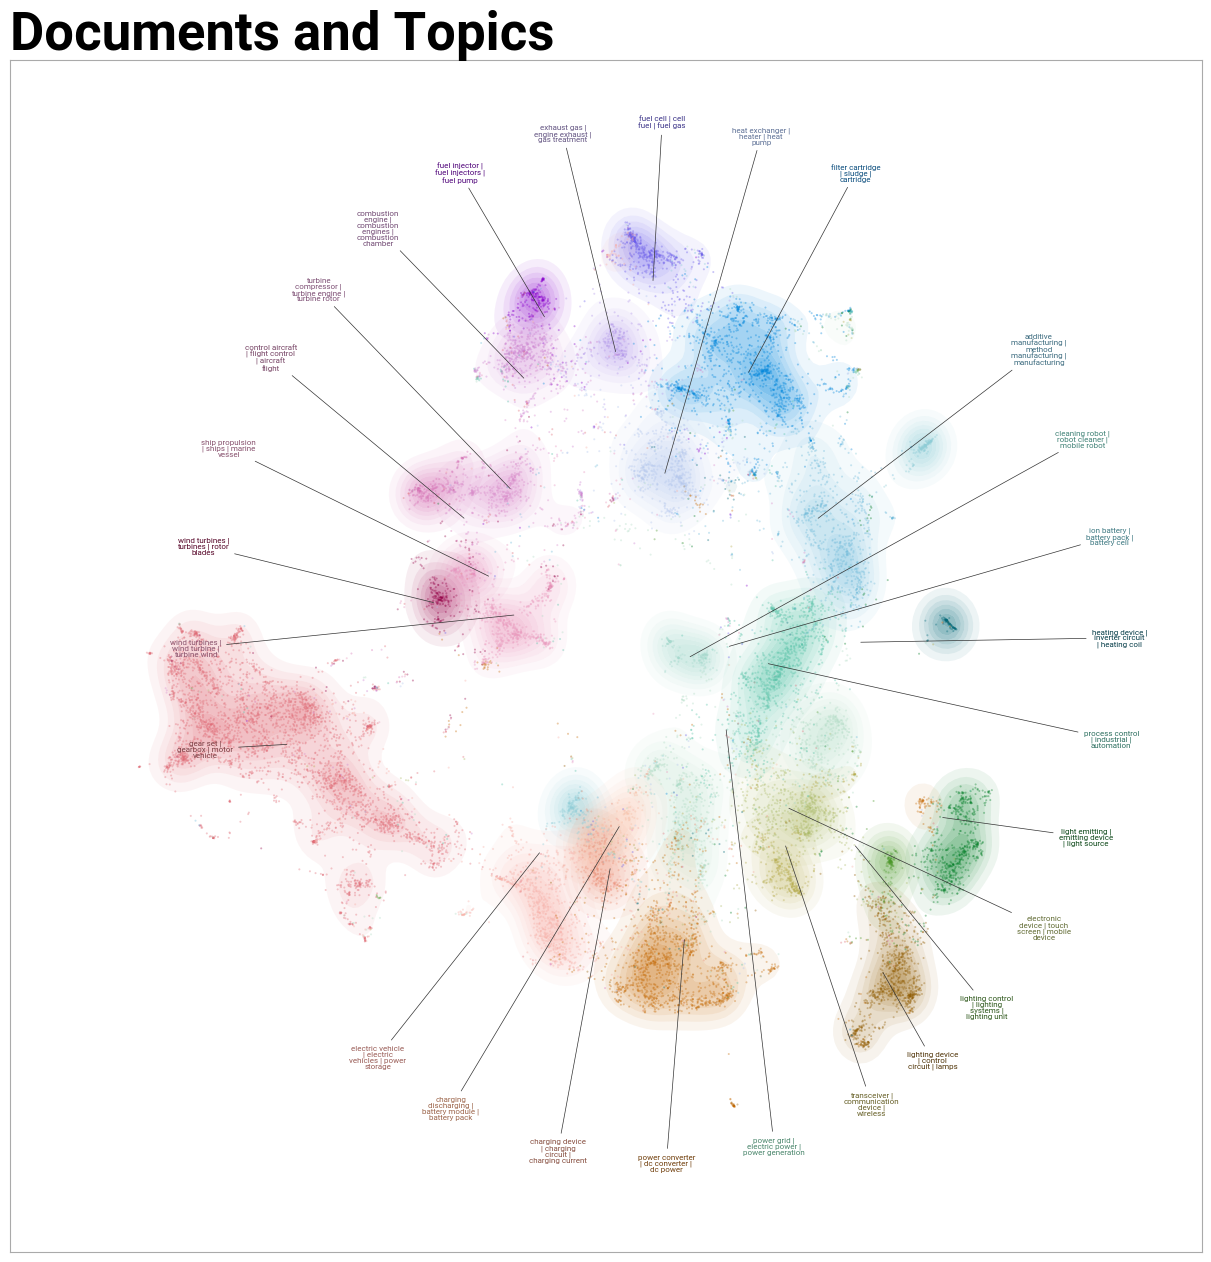

In [81]:
# Run the visualization with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings_specter)

# with the reduced embeddings
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings_specter)
topic_model.visualize_document_datamap(abstracts, reduced_embeddings=reduced_embeddings, custom_labels=True)

# llama topic model

In [4]:
import pandas as pd
sectors = ["Mobility", "Mobility", "Mobility", "Mobility",
             "Electronics", "Electronics", "Electronics", "Electronics",
                "Electronics", "Electronics", "Electronics", "Electronics", "Electronics",
                "Production", "Production",
                 "Energy", "Energy", "Energy", "Energy", "Energy", "Energy",
                "Energy", "Energy",
                "Energy", "Energy", "Energy",
                
                "Environment", "Environment",  "Environment",  "Environment", 
                "ICT", "ICT", "ICT", "ICT"]

technologies = ["Ships & propulsion", "Aircrafts","Automotive", "Automotive",
                 "Robotics", "Microwave & cooking", "Lighting", "Lighting", 
                 "Battery", "Battery", "Battery", "Battery", "Battery",
                 "Smart", "Hybrid",
                 "Gas turbines", "Heat pumps", "Solar energy", "Nuclear reactors", "Power conversion","Power conversion",
                 "Fuel cells", "Fuel cells",
                 "Wind energy", "Wind energy", "Wind energy",
                 
                 "Air filtering", "Waste treatment", "CCS", "Hyroponics",
                 "Touchscreens", "Mobile devices", "Wireless c.", "Sensors"]

topics = [None, None, "Transmission", "Combustion engine",
          None, None, "LED lighting", "Other",
          "Charging", "Management", "Monitoring", "Modular","Lithium", 
          None, None,
          None, None, None, None, "Power conversion", "EV charging",
          "System design", "Power supply",
          "Farm control", "Turbine monitoring", "Drivetrains",
          
          None, None, None, None,
          None, None, None, None]
patents = [181, 229, 2774, 921,
           194, 128, 923, 537,
           366, 358,  596, 211,182,
           919, 725, 
           469, 677, 203, 114, 1080, 680,
           371, 175,
           168, 467, 298,
           
           472, 497, 420, 127,
           277, 366, 392, 805]
import textwrap 
def customwrap(s, width=12):
    if s is None:
        return None
    return "<br>".join(textwrap.wrap(s, width=width))

topics = list(map(customwrap, topics))
technologies = list(map(customwrap, technologies))
sectors = list(map(customwrap, sectors))


df = pd.DataFrame(dict(sectors=sectors, technologies=technologies, topics=topics, patents=patents))
# Define a custom order for 'sectors'
#sector_order = ['Mobility', 'Environmental', 'Electronics', "ICT", "Energy", "Manufacturing"]  # Custom order

#df['sectors'] = pd.Categorical(df['sectors'], categories=sector_order, ordered=True)

# Sort the DataFrame by 'sectors'
#df.sort_values('sectors', inplace=True)
# Sort the DataFrame by 'sectors' and 'patents' in descending order
df_sorted = df.sort_values(by=['sectors', 'patents'], ascending=[True, False])

import warnings

# Suppress specific FutureWarning from Pandas/Plotly
warnings.simplefilter(action='ignore', category=FutureWarning)


In [5]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Color map including sectors, technologies, and topics
color_map = {
    
    'Energy': '#0a325e',  
    
    'Environment': '#7788a6', 
     
    'Production': '#61656a', 
    'ICT': '#b4d1b6',  
    'Electronics': '#6bae77', 
    'Mobility': '#024d23' 

}

color_map2 = {
    
    'Energy(27.2%)': '#0a325e',  
    'Mobility (23.7%)': '#024d23',
    'Electronics (20.2%)': '#6bae77', 
    'ICT (10.6%)': '#b4d1b6', 
    'Production (9.5%)': '#61656a', 
    'Environment(8.8%)': '#7788a6', 

}



# Create the sunburst chart
fig = px.sunburst(df, path=['sectors', 'technologies', 'topics'], values='patents',
                  color='sectors', hover_data=['patents'],
                  color_discrete_map=color_map,
                  #color_discrete_sequence=px.colors.qualitative.Prism,
                  title='Distribution of Patents Across Categories')

# Manually add legend elements
legend_x = 1.05  # x position for the start of the legend
legend_y = 1    # y position for the start of the legend
for i, (sector, color) in enumerate(color_map2.items()):
    fig.add_shape(type="rect",
                  x0=legend_x, y0=legend_y - i * 0.1, x1=legend_x + 0.05, y1=legend_y - i * 0.1 + 0.05,
                  line=dict(color=color),
                  fillcolor=color)
    fig.add_annotation(x=legend_x + 0.07, y=legend_y - i * 0.1 + 0.025,
                       text=sector,
                       showarrow=False,
                       xanchor='left',
                       yanchor='middle')

fig.update_layout(margin=dict(t=250, l=250, r=250, b=250), font= dict(
        family="Roboto Mono, monospace",  # Font family
        size=18
        ), 
        title_font_size= 15,
        uniformtext=dict(minsize=10, mode='hide'),
        hovermode = 'closest',
        width=750,height=750,
        showlegend=True)
fig.update_layout(
    legend_title_text='Sectors',
    legend=dict(
        title_font=dict(size=16, color='blue'),
        font=dict(size=12, color='black'),
        bgcolor='LightSteelBlue',
        bordercolor='Black',
        borderwidth=2
    )
)
fig.update_traces(insidetextorientation='radial') 
#fig.update_traces(sort=False, selector=dict(type='sunburst')) 
fig.show()
# Save the figure
pio.write_image(fig, 'sunburst_chart_legend_small.png', scale=5)  # Adjust scale for higher resolution


In [27]:
df_sorted

,sectors,technologies,topics,patents
2,Mobility,Automotive,Transmission,2774
3,Mobility,Automotive,Combustion engine,921
1,Mobility,Aircrafts,None,229
0,Mobility,Ships & propulsion,None,181
27,Environmental,Waste treatment,None,497
26,Environmental,Air filtering,None,472
28,Environmental,Carbon removal and utilisation,None,420
29,Environmental,Hydroponic plant cultivation,None,127
6,Electronics,Lighting,LED lighting,923
10,Electronics,Battery,Monitoring,596


## large

In [35]:
import pandas as pd
sectors = ["Mobility", "Mobility", "Mobility", "Mobility",
             "Electronics", "Electronics", "Electronics", "Electronics",
                "Electronics", "Electronics", "Electronics", "Electronics", "Electronics",
                "Production", "Production",
                 "Energy", "Energy", "Energy", "Energy", "Energy", "Energy",
                "Energy", "Energy",
                "Energy", "Energy", "Energy",
                
                "Environment", "Environment",  "Environment",  "Environment", 
                "ICT", "ICT", "ICT", "ICT"]

technologies = ["Ships & propulsion", "Aircrafts","Automotive", "Automotive",
                 "Robotics", "Microwave & cooking", "Lighting", "Lighting", 
                 "Battery", "Battery", "Battery", "Battery", "Battery",
                 "Smart", "Hybrid",
                 "Gas turbines", "Heat pumps", "Solar energy", "Nuclear reactors", "Power conversion","Power conversion",
                 "Fuel cells", "Fuel cells",
                 "Wind energy", "Wind energy", "Wind energy",
                 
                 "Air filtering", "Waste treatment", "CCS", "Hyroponics",
                 "Touchscreens", "Mobile devices", "Wireless comm.", "Sensors"]

topics = [None, None, "Transmission", "Combustion engine",
          None, None, "LED lighting", "Other",
          "Charging", "Management", "Monitoring", "Modular","Lithium", 
          None, None,
          None, None, None, None, "Power conversion", "EV charging",
          "System design", "Power supply",
          "Farm control", "Turbine monitoring", "Drivetrains",
          
          None, None, None, None,
          None, None, None, None]
patents = [184, 233, 2791, 923,
           198, 143, 1003, 578,
           460, 400,  798, 230,183,
           988, 731, 
           471, 692, 203, 114, 2234, 765,
           371, 176,
           169, 467, 298,
           
           472, 497, 420, 127,
           365, 460, 658, 992]
import textwrap 
def customwrap(s, width=12):
    if s is None:
        return None
    return "<br>".join(textwrap.wrap(s, width=width))

topics = list(map(customwrap, topics))
technologies = list(map(customwrap, technologies))
sectors = list(map(customwrap, sectors))


df = pd.DataFrame(dict(sectors=sectors, technologies=technologies, topics=topics, patents=patents))
# Define a custom order for 'sectors'
#sector_order = ['Mobility', 'Environmental', 'Electronics', "ICT", "Energy", "Manufacturing"]  # Custom order

#df['sectors'] = pd.Categorical(df['sectors'], categories=sector_order, ordered=True)

# Sort the DataFrame by 'sectors'
#df.sort_values('sectors', inplace=True)
# Sort the DataFrame by 'sectors' and 'patents' in descending order
df_sorted = df.sort_values(by=['sectors', 'patents'], ascending=[True, False])

import warnings

# Suppress specific FutureWarning from Pandas/Plotly
warnings.simplefilter(action='ignore', category=FutureWarning)


In [39]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Color map including sectors, technologies, and topics
color_map = {
    
    'Energy': '#0a325e',  
    
    'Environment': '#7788a6', 
     
    'Production': '#61656a', 
    'ICT': '#b4d1b6',  
    'Electronics': '#6bae77', 
    'Mobility': '#024d23' 

}



# Create the sunburst chart
fig = px.sunburst(df, path=['sectors', 'technologies', 'topics'], values='patents',
                  color='sectors', hover_data=['patents'],
                  color_discrete_map=color_map,
                  #color_discrete_sequence=px.colors.qualitative.Prism,
                  title='Distribution of Patents Across Categories')


fig.update_layout(margin=dict(t=50, l=50, r=50, b=50), font= dict(
        family="Roboto Mono, monospace",  # Font family
        size=18
        ), 
        title_font_size= 15,
        uniformtext=dict(minsize=10, mode='hide'),
        hovermode = 'closest',
        width=850,height=850,
        showlegend=True)
fig.update_layout(
    legend_title_text='Sectors',
    legend=dict(
        title_font=dict(size=16, color='blue'),
        font=dict(size=12, color='black'),
        bgcolor='LightSteelBlue',
        bordercolor='Black',
        borderwidth=2
    )
)
fig.update_traces(insidetextorientation='radial') 
#fig.update_traces(sort=False, selector=dict(type='sunburst')) 
fig.show()
# Save the figure
pio.write_image(fig, 'sunburst_chart_large.png', scale=5)  # Adjust scale for higher resolution


In [41]:
df

,sectors,technologies,topics,patents
0,Mobility,Ships &<br>propulsion,None,184
1,Mobility,Aircrafts,None,233
2,Mobility,Automotive,Transmission,2791
3,Mobility,Automotive,Combustion<br>engine,923
4,Electronics,Robotics,None,198
5,Electronics,Microwave &<br>cooking,None,143
6,Electronics,Lighting,LED lighting,1003
7,Electronics,Lighting,Other,578
8,Electronics,Battery,Charging,460
9,Electronics,Battery,Management,400


In [52]:
sector_patents_sum = df.groupby('sectors')['patents'].sum()

sector_patents_percentage = (sector_patents_sum / 17302) * 100

# Display the result
print(sector_patents_percentage)


sectors
Electronics    20.199977
Energy         27.176049
Environment     8.761993
ICT            10.634609
Mobility       23.725581
Production      9.501792
Name: patents, dtype: float64
